<a href="https://colab.research.google.com/github/ewst22ParkSY/ESAA11_PSY/blob/ESAA11_OB/ESAA_OB_WEEK12_1_transcript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

딥러닝 파이토치 교과서 ch5. 2 p.179~200



---



## 5.2 합성곱 신경망 맛보기
fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현하기

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [3]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# fashion_mnist 데이터셋 내려받기

train_dataset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST', train=True,
    download=True, transform=transforms.ToTensor())

test_dataset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST', train=False,
    download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.87MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 60.5MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.4MB/s]


torchvision 파라미터
1. ```./data/FashionMNIST``` : FashionMNIST 내려받을 위치 지정
2. ```download=``` : Download를 True로 변경해주면 첫 번째 파라미터의 위치에 해당 데이터셋이 있는지 확인 후 내려받는다.
3. transform: 이미지를 텐서(0~1)로 변경



In [5]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = 100)

```torch.utils.data.DataLoader()```를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나 순서가 무작위로 섞이도록(shuffle) 할 수 있음.

데이터로더에서 사용하는 파라미터
1. 첫번째 파라미터: 데이터를 불러올 데이터셋 지정
2. ```batch_size```: 데이터를 배치로 묶어줌.



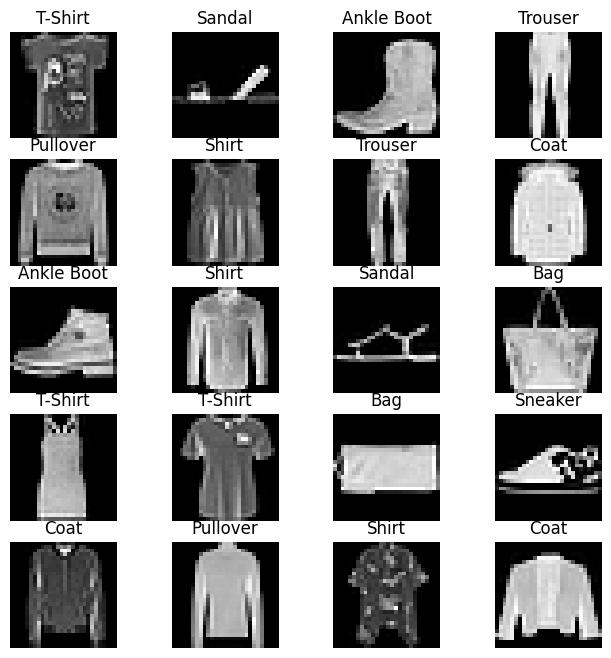

In [6]:
# 분류에 사용될 클래스 정의
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 :'Dress', 4 :'Coat',
              5 : 'Sandal', 6 :'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'} # 열 개의 클래스

fig = plt.figure(figsize=(8,8)); #출력할 이미지의 가로세로 길위로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
  img_xy = np.random.randint(len(train_dataset)); # 1
  img = train_dataset[img_xy][0][0,:,:] # 2
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() #20개의 이미지 데이터를 시각적으로 표현

1. ```np.random```은 무작위로 데이터를 생성할 때 사용. ```np.random.randint()```는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용

```python
#random.randint와 유사하게 사용되는 random.rand와 random.randn을 예시로 살펴보기

import numpy as np
np.random.randint(10) # 0~10의 임의의 숫자를 출력
np.random.randint(1, 10) # 1~9의 임의의 숫자를 출력
np.random.rand(8) # 0~1사이의 정규표준분포 난수를 행렬로 (1x8) 출력
np.random.rand(4, 2) # 0~1 사이의 정규분포 난수를 행렬로 (4x2) 출력
```

2. ```train_dataset```을 이용한 3차원 배열을 생성

```python
import numpy as np
examp = np.arange(0, 100, 3) # 1~99의 숫자에서 3씩 건너뛴 행렬 생성
examp.resize(6, 4) # 행렬의 크기를 6x4로 조정
```


In [7]:
# 심층 신경망 모델 생성

class FashionDNN(nn.Module):
    def __init__(self): # 1
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256) # 2
        self.drop = nn.Dropout(0.25) # 3
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data): # 4
        out = input_data.view(-1, 784) # 5
        out = F.relu(self.fc1(out)) # 6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out



1. 클래스 형태의 모델은 항상 ```torch.nn.Module```을 상속 받음. ```__init__()```은 객체가 갖는 속성 값을 초기화하는 역할을 하며 객체가 생성될 때 자동으로 호출됨. ```super(FashionDNN, self).__init__()```은 ```nn.Module```클래스를 상속받겠다는 의미.

2. nn은 딥러닝 모델(네트워크) 구서엥 필요한 모듈이 모여 있는 패키지이며, Linear는 단순 선형 회귀 모델을 만들 때 사용.
```python
nn.Linear(in_features=784, out_features=256)
```
  a. ```in_features```: 입력의 크기(input size)
  b. ```out_features```: 출력의 크기(output size)

- 실제로 데이터 연산이 진행되는 forward() 부분에는 첫 번째 파라미터 값만 넘겨주게 되며, 두 번째 파라미터에 정의된 크기가 forward() 연산의 결과가 됨.

3. ```torch.nn.Dropout(p)``` : p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커짐.

4. ```forward()``` : 모델이 학습 데이터를 입력받아 순전파(forward propagation) 학습을 진행, 반드시 forward라는 이름의 함수여야 함. 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수이며, 객체를 데이터와 함께 호출하면 자동으로 실행됨.

5. 파이토치에서 사용하는 뷰(view)는 넘파이의 reshape와 같은 역할로 텐서의 크기(shape)를 변경해 주는 역할을 함. 첫번째 차원은 사용자가 잘 모르겠으니 파이토치에 맡기겠다는 의미이고 두번째 차원의 길이는 784를 가지도록 하라는 의미임

6. 활성화 함수를 지정할 때는 다음 두 가지 방법이 가능
  - F.relu(): forward() 함수에서 정의
  - nn.ReLU(): __init__() 함수에서 정의
  - 차이점: 사용하는 위치

nn을 사용하는 코드
```python
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d(1, 1, 3)
```

nn.functional을 사용하는 예시 코드
```python
import torch.nn.functional as F

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs=  F.conv2d(inputs, weight, bias, padding=1)
```



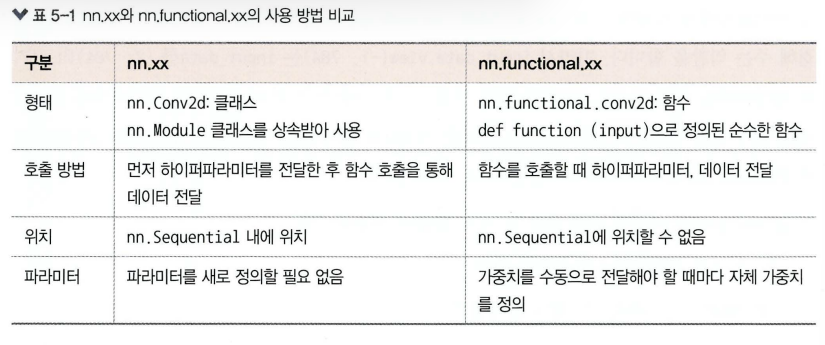

In [8]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


1. 옵티마이저를 위한 경사 하강법은 Adam을 사용하며, 학습률을 의미하는 lr은 0.001을 사용한다는 의미



In [9]:
# 심층 신경망을 이용한 모델 학습

num_epochs = 5
count = 0
loss_list = []    # 1
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:   # 2
        images, labels = images.to(device), labels.to(device)  # 3

        train = images.view(100, 1, 28, 28)  # 4
        labels = labels

        outputs = model(train)   # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):    # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = images.view(100, 1, 28, 28)

                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total   # 5
            loss_list.append(loss.data)       # 1'
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data,
                                                                  accuracy))

Iteration: 500, Loss: 0.591550350189209, Accuracy: 83.02999877929688%
Iteration: 1000, Loss: 0.4853585362434387, Accuracy: 84.47000122070312%
Iteration: 1500, Loss: 0.3884463906288147, Accuracy: 83.90999603271484%
Iteration: 2000, Loss: 0.42022082209587097, Accuracy: 84.90999603271484%
Iteration: 2500, Loss: 0.27800729870796204, Accuracy: 85.79000091552734%
Iteration: 3000, Loss: 0.2887113392353058, Accuracy: 86.08999633789062%




1. 1, : 일반적으로 배열이나 행렬과 같은 리스트(list)를 사용하는 방법은 다음과 같음
  - 1과 같이 비어있는 배열이나 행렬 만들기
  - 1' 처럼 append 메서드를 이용해 데이터를 하나씩 추가함

2. for 구문을 사용해 레코드(행, 가로줄)를 하나씩 가져옴. 이 때 for x, y in train:과 같이 in 앞에 변수를 두 개 지정해주면 레코드에서 요소 두 개를 꺼내오겠다는 의미

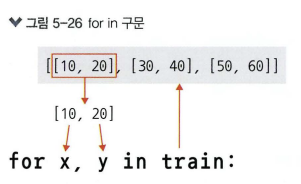

3. 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함.

4. Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미분에 대한 값을 저장하기 위해 테이프(tape)를 사용함. 순전파(forward) 단계에서 테이프는 수행하는 모든 연산을 저장, 역전파(backward) 단계에서 저장된 값들을 꺼내서 사용.


5. 분류 문제에 대한 정확도는 전체 예측에 대한 정확한 예측의 비율로 표현할 수 있음.

<분류 문제에서 클래스가 세 개 이상일 때의 주의사항>
- 정확도가 80%라고 할 때, 80%라는 값이 모든 클래스가 동등하게 고려된 것인지, 특정 클래스의 분류가 높았던 것인지에 대해 알 수 없음에 유의
- 정확도가 90%이상이라고 할 때, 100개의 데이터 중 90개가 하나의 클래스에 속할 경우 90%의 정확도는 높다고 할 수 없음. 즉 모든 데이터를 특정 클래스에 속한다고 예측해도 90%의 예측 결과가 나오기 때문에 데이터 특성에 따라 정확도를 잘 관측해야 함

In [10]:
# 합성곱 네트워크 생성

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential( # 1
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1), # 2
            nn.BatchNorm2d(32), #3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ## 4
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)   # 5
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)   # 마지막 계층의 out_features는 클래스 개수를 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out



1. nn.Sequential을 사용하면 __init__()에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라 forward() 함수에서 구현될 순전파를 계층(layer) 형태로 좀 더 가독성이 뛰어난 코드로 작성할 수 있음
- nn.Sequential은 계층을 차례로 쌓을 수 있도록 $W_x + b$와 같은 수식과 활성화 함수를 연결해주는 역할을 함. 특히 데이터가 각 계층을 순차적으로 지나갈 때 사용하면 좋은 방법임. 정리하면 nn.Sequential은 여러 개의 계층을 하나의 컨테이너에 구현하는 방법임

2. 합성곱층(cov layer)은 합성곱 연산을 통해서 이미지의 특징을 추출함. 합성곱이란 커널(또는 필터)이라는 n x m 크기의 행렬이 높이(height) x 너비(width) 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력함. 커널은 일반적으로 3x3이나 5x5를 사용하며 파라미터는 다음과 같음
```python
nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
```
a. ```in_channels```: 입력 채널의 수
<br>b. ```out_channels```: 출력 채널의 수를 의미
<br>c. ```kernel_size```: 커널 크기를 의미하며 논문에 따라 필터라고도 함. 이미지 특징을 찾아내기 위한 공용 파라미터이며, CNN에서 학습 대상은 학습 파라미터가 됨. 입력 데이터를 스트라이드 간격으로 순회하면서 합성곱을 계산함.
<br>d.```padding```: 패딩 크기를 의미하는 거승로 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채움. 패딩 값이 클수록 출력 크기도 커짐.

3. ```BathNorm2d```: 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미함.

4. ```MaxPool2d```: 이미지 크기를 축소시키는 용도로 사용함. 풀링 계층은 합성곱층의 출력 데이터를 입력으로 받아서 출력 데이터(activation map)의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용됨. 최대 풀링과 평균 풀링, 최소 풀링이 존재하며 파라미터로는 ```kernel_size```와 ```stride```이 있음.

5. 클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야 함. Conv2d에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기(output size)가 달라짐. > 패딩과 스트라이드의 값에 따라 출력 크기가 달라짐. 이렇게 줄어든 출력 크기는 최종적으로 분류를 담당하는 완전연결층(fully connected layer)으로 전달


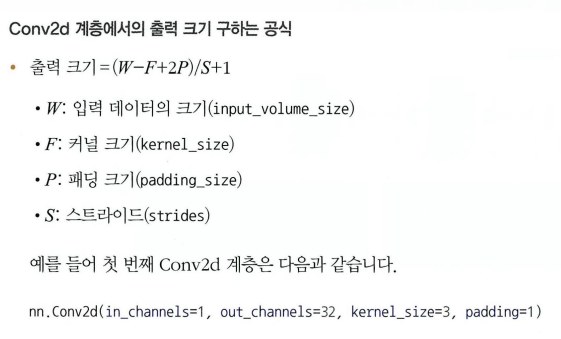

MaxPool2d 계층에서의 출력 크기 구하는 공식<br>
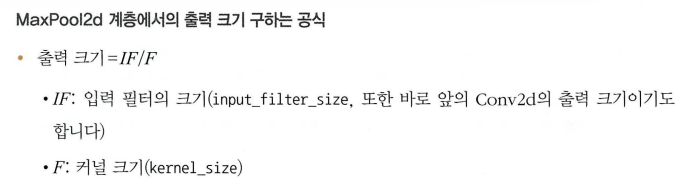

6. 합성곱층에서 완전연결층으로 변경되기 때문에 데이터의 형태를 1차원으로 바꾸어줌.

In [11]:
# 합성곱 네트워크를 위한 파라미터 정의

learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
# 모델 학습 및 성능 평가

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = images.view(100, 1, 28, 28)
        labels = labels

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images , labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = images.view(100, 1, 28, 28)
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {},%".format(count, loss.data,
                                                                   accuracy))

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.44737035036087036, Accuracy: 87.66999816894531,%
Iteration: 1000, Loss: 0.4044494926929474, Accuracy: 88.65999603271484,%
Iteration: 1500, Loss: 0.26172274351119995, Accuracy: 88.15999603271484,%
Iteration: 2000, Loss: 0.18983672559261322, Accuracy: 88.56999969482422,%
Iteration: 2500, Loss: 0.20525620877742767, Accuracy: 89.56999969482422,%
Iteration: 3000, Loss: 0.1923297494649887, Accuracy: 90.37999725341797,%
